In [1]:
import warnings
warnings.filterwarnings('ignore')

# Build the target classes 

In [2]:
import os 
import glob
xml_files = glob.glob('./data/xml/*.xml')

In [3]:
import xml.etree.ElementTree as ET
dict_word_class = {}
for xml_ in xml_files: 
    tree = ET.parse(xml_)
    root = tree.getroot()
    lines = root.findall('handwritten-part')[0].findall('line')
    for line in lines: 
        words = line.findall('word')
        for w in words: 
            dict_word_class[w.attrib['id']] = w.attrib['text']

In [4]:
import pandas as pd 
frame = pd.DataFrame(list(dict_word_class.keys()))

In [5]:
frame['label'] = list(dict_word_class.values())

In [6]:
frame.head(5)

,0,label
0,d06-050-00-00,Nor
1,d06-050-00-01,is
2,d06-050-00-02,she
3,d06-050-00-03,necessarily
4,d06-050-00-04,being


- We have 13550 unique words for 115320 images : 

In [7]:
frame.label.nunique(), frame.shape

(13550, (115320, 2))

- Convert labels to ids :

In [8]:
from collections import Counter
# count frequency of words 
words_frequency = Counter(frame['label'])

In [9]:
words_to_keep = [w for w,v in words_frequency.items() if v > 1]
len(words_to_keep)

6360

In [10]:
#words to ids : 
label_dict_word_to_id = dict(zip(words_to_keep, list(range(len(words_to_keep)))))

#ids to words : 
label_id_to_word = dict(zip(list(range(len(words_to_keep))), words_to_keep))

label_dict_word_to_id['the'], label_id_to_word[12]

(12, 'the')

In [11]:
#convert words to labels: 
frame['label'] = frame['label'].map(label_dict_word_to_id)
frame = frame.dropna()

In [12]:
frame.head(5)

,0,label
0,d06-050-00-00,0.0
1,d06-050-00-01,1.0
2,d06-050-00-02,2.0
3,d06-050-00-03,3.0
4,d06-050-00-04,4.0


- Split dataframe to Train and test: 

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
skf = StratifiedShuffleSplit(2, test_size=0.1, random_state=42)

In [14]:
for train, test in skf.split(frame[0], frame['label']):
    train_idx, test_idx = train, test 

In [15]:
train = frame.iloc[train_idx, :]
test = frame.iloc[test_idx, :]

In [16]:
for i in train.iterrows(): 
    break

In [17]:
i[1][0]

'f01-053-02-00'

## Data Loader 

In [18]:
%%time
import cv2
import numpy as np
from PIL import Image
import PIL
def get_data(frame): 
    """
    frame with words image files and their labels 
    """
    x_train, y_train = [], []
    
    x_test, y_test = [], []
    
    for row in train.iterrows(): 
        try: 
            i = row[1][0]
            target = row[1]['label']
            l = i.split('-')
            path_img = os.path.join(l[0], l[0]+'-'+l[1], i+'.png')
            # convert img to gray scale array 
            x=Image.open('./data/words/'+path_img,'r')

            x=x.convert('L') #makes it greyscale
            
            x = x.resize((28, 28), PIL.Image.ANTIALIAS)

            y=np.asarray(x.getdata(),dtype=np.float64).reshape((x.size[1],x.size[0]))

            
            y=np.asarray(y,dtype=np.uint8)

            x_train.append(y)
            
            y_train.append(target)
        except Exception as e : 
            print(e)
            pass

    
    for row in test.iterrows(): 
        try: 
            i = row[1][0]
            target = row[1]['label']
            l = i.split('-')
            path_img = os.path.join(l[0], l[0]+'-'+l[1], i+'.png')
            # convert img to gray scale array 
            x=Image.open('./data/words/'+path_img,'r')

            x=x.convert('L') #makes it greyscale
            
            x = x.resize((28, 28), PIL.Image.ANTIALIAS)

            y=np.asarray(x.getdata(),dtype=np.float64).reshape((x.size[1],x.size[0]))

            
            y=np.asarray(y,dtype=np.uint8)

            x_test.append(y)
            
            y_test.append(target)
            
        except Exception as e : 
            print(e)
            pass

    return (np.array(x_train),y_train), (np.array(x_test),y_test)

CPU times: user 29.8 ms, sys: 35.1 ms, total: 65 ms
Wall time: 153 ms


In [19]:
%%time
(x_train, train_labels), (x_test, test_labels) = get_data(frame)

cannot identify image file './data/words/r06/r06-022/r06-022-03-05.png'
cannot identify image file './data/words/a01/a01-117/a01-117-05-02.png'
CPU times: user 1min 50s, sys: 33.2 s, total: 2min 23s
Wall time: 3min 31s


In [20]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=x_train.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=x_test.shape))

Training set (images) shape: (97316, 28, 28)
Test set (images) shape: (10812, 28, 28)


In [21]:
# Re-size the images to prepare input of convolutional network 
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [22]:
## Display some images examples : 

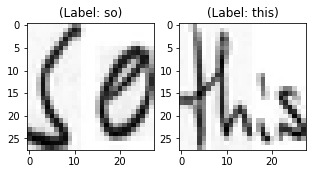

In [23]:
import matplotlib.pylab as plt
%matplotlib inline
plt.figure(figsize=[5,5])
# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_id_to_word[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_id_to_word[curr_lbl]) + ")")
plt.show()

### data pre-processing

In [24]:
train_data = x_train.reshape(-1, 28,28, 1)
test_data = x_test.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((97316, 28, 28, 1), (10812, 28, 28, 1))

In [25]:
# ground truth
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.1, 
                                                             random_state=13)

<h1> <center> Convolutional Image aute-encoder </center> </h1>

- Le but est d'entrainer un modèle capable de comprendre l'écriture manuscrite. l'entrée est l'image. La sortie aussi. On cherche à minimiser l'erreur de reconstruction. 

In [26]:
from keras.layers import *
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

Using TensorFlow backend.


## Define the model 

In [27]:
from keras.layers import Input, Dense
from keras.models import Model

#encoder
#input = 28 x 28 x 1 (wide and thin)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    
#decoder
conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1


In [28]:
from keras.metrics import *
from keras.optimizers import *
encoder = Model(input_img, conv3)
autoencoder = Model(input_img, decoded)
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [29]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         147584    
__________

### Fit the model

In [30]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=6,verbose=1,validation_data=(valid_X, valid_ground))

Train on 87584 samples, validate on 9732 samples
Epoch 1/6
87584/87584 [==============================] - 283s - loss: 0.0181 - val_loss: 0.0090
Epoch 2/6
87584/87584 [==============================] - 279s - loss: 0.0067 - val_loss: 0.0053
Epoch 3/6
87584/87584 [==============================] - 278s - loss: 0.0046 - val_loss: 0.0039
Epoch 4/6
87584/87584 [==============================] - 272s - loss: 0.0038 - val_loss: 0.0044
Epoch 5/6
87584/87584 [==============================] - 271s - loss: 0.0033 - val_loss: 0.0031
Epoch 6/6
87584/87584 [==============================] - 274s - loss: 0.0030 - val_loss: 0.0024


l'erreur est de 0.2%

### Visualize Train Validation loss :

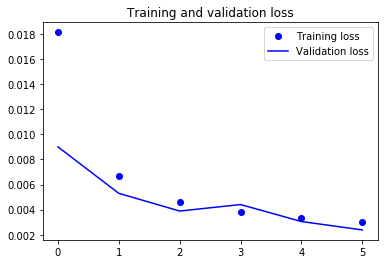

In [31]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(6)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Visualize the aute-encoding results 

In [32]:
pred = autoencoder.predict(test_data)

Test Images


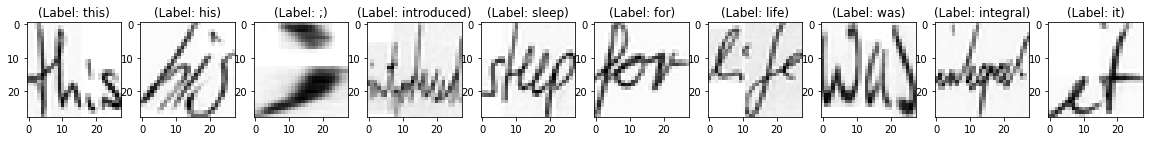

Reconstruction of Test Images


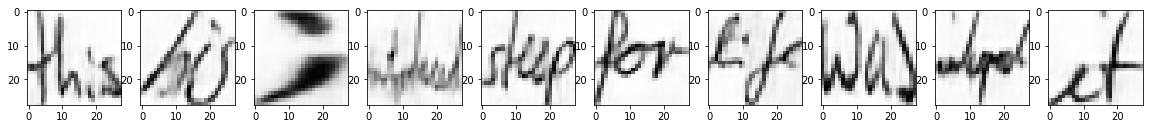

In [33]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_id_to_word[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

<center> <h1>Convolution Classification task </h1> </center>

- Une fois notre auto-encoder a appris à reconstruire l'écriture manuscrite, on définira une couche supérieur de classification qui a pour but de calculer un vecteur de probabilité de longueur le nombre de mots unique qu'on cherche à classer. On affecte à l'image la classe du mot avec la plus grande probabilité. 

## Convert labels to one-hot encoding

In [34]:
from keras.utils import to_categorical
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_labels)
test_Y_one_hot = to_categorical(test_labels)

# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 205.0
After conversion to one-hot: [0. 0. 0. ... 0. 0. 0.]


In [35]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,
                                                           test_size=0.1,random_state=13)

### Define the classification model 

In [40]:
num_classes = len(words_to_keep)
num_classes
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [41]:
encode = conv4
full_model = Model(input_img, fc(encode))

In [42]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         147584    
__________

In [43]:
for l1,l2 in zip(full_model.layers[:5],autoencoder.layers[0:5]):
    l1.set_weights(l2.get_weights())

### Transfer Learning :  Use the pre-trained auto-encoder to help the classifier in the detection of the words 

In [44]:
for layer in full_model.layers[0:5]:
    layer.trainable = False

In [45]:
import keras
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [46]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=10,verbose=1,validation_data=(valid_X, valid_label))

Train on 87584 samples, validate on 9732 samples
Epoch 1/10
87584/87584 [==============================] - 136s - loss: 4.3977 - acc: 0.3783 - val_loss: 3.7170 - val_acc: 0.4457
Epoch 2/10
87584/87584 [==============================] - 126s - loss: 3.0429 - acc: 0.5099 - val_loss: 3.1462 - val_acc: 0.5244
Epoch 3/10
87584/87584 [==============================] - 128s - loss: 2.3072 - acc: 0.5824 - val_loss: 2.8768 - val_acc: 0.5526
Epoch 4/10
87584/87584 [==============================] - 132s - loss: 1.7433 - acc: 0.6460 - val_loss: 2.8918 - val_acc: 0.5756
Epoch 5/10
87584/87584 [==============================] - 127s - loss: 1.2983 - acc: 0.7125 - val_loss: 2.9873 - val_acc: 0.5780
Epoch 6/10
87584/87584 [==============================] - 126s - loss: 0.9641 - acc: 0.7720 - val_loss: 3.1464 - val_acc: 0.5749
Epoch 7/10
87584/87584 [==============================] - 128s - loss: 0.7166 - acc: 0.8249 - val_loss: 3.2322 - val_acc: 0.5721
Epoch 8/10
87584/87584 [========================

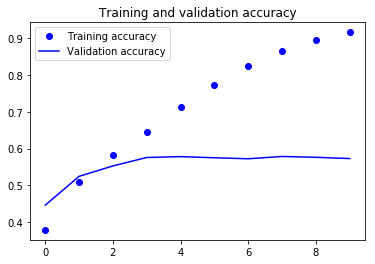

In [62]:
loss = full_model.history.history['acc']
val_loss = full_model.history.history['val_acc']
epochs = range(10)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [63]:
full_model.save_weights('autoencoder_classification.h5')

### Re-train the model with all layer unfrozen : Adapt to our specific classification task 

In [64]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

In [65]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [73]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=4,verbose=1,
                                validation_data=(valid_X, valid_label))

Train on 87584 samples, validate on 9732 samples
Epoch 1/4
87584/87584 [==============================] - 158s - loss: 0.4710 - acc: 0.8824 - val_loss: 3.8669 - val_acc: 0.5680
Epoch 2/4
87584/87584 [==============================] - 154s - loss: 0.3563 - acc: 0.9129 - val_loss: 4.0634 - val_acc: 0.5673
Epoch 3/4
87584/87584 [==============================] - 155s - loss: 0.3274 - acc: 0.9213 - val_loss: 3.9669 - val_acc: 0.5713
Epoch 4/4
87584/87584 [==============================] - 154s - loss: 0.3087 - acc: 0.9283 - val_loss: 4.2416 - val_acc: 0.5706


In [77]:
full_model.save_weights('classification_complete.h5')

In [78]:
predicted_classes = full_model.predict(test_data)

In [79]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [80]:
predicted_classes.shape, np.array(test_labels).shape

((10812,), (10812,))

Found 6286 correct labels


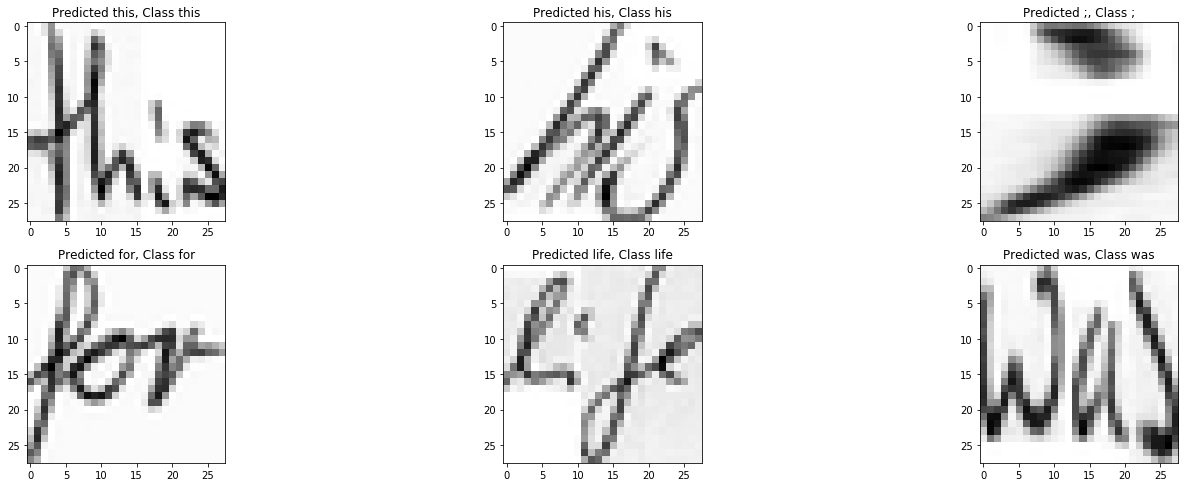

In [81]:
correct_ = np.where(predicted_classes==test_labels)[0]
print ("Found %d correct labels" % len(correct_))
plt.figure(figsize=(20,10))
for i, correct in enumerate(correct_[:6]):
    plt.subplot(3,3, i+1)
    plt.imshow(test_data[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(label_id_to_word[predicted_classes[correct]],
                                              label_id_to_word[test_labels[correct]]))
plt.tight_layout()

In [92]:
f = pd.DataFrame(list(Counter(test_labels).keys()))
f['freq'] = list(Counter(test_labels).values())

In [106]:
pred_frame = pd.DataFrame(predicted_classes)

In [107]:
test_frame = pd.DataFrame(test_labels)

In [116]:
acc = {}
for freq, ids in f.groupby('freq').groups.items(): 
    test_lab_freq = test_frame.iloc[ids,:]
    preds_freq = pred_frame.iloc[ids,:]
    acc[freq] = ((preds_freq==test_lab_freq)/len(test_lab_freq)).values[0][0]  

In [121]:
data = pd.DataFrame(list(acc.values()))
data['freq'] = acc.keys()

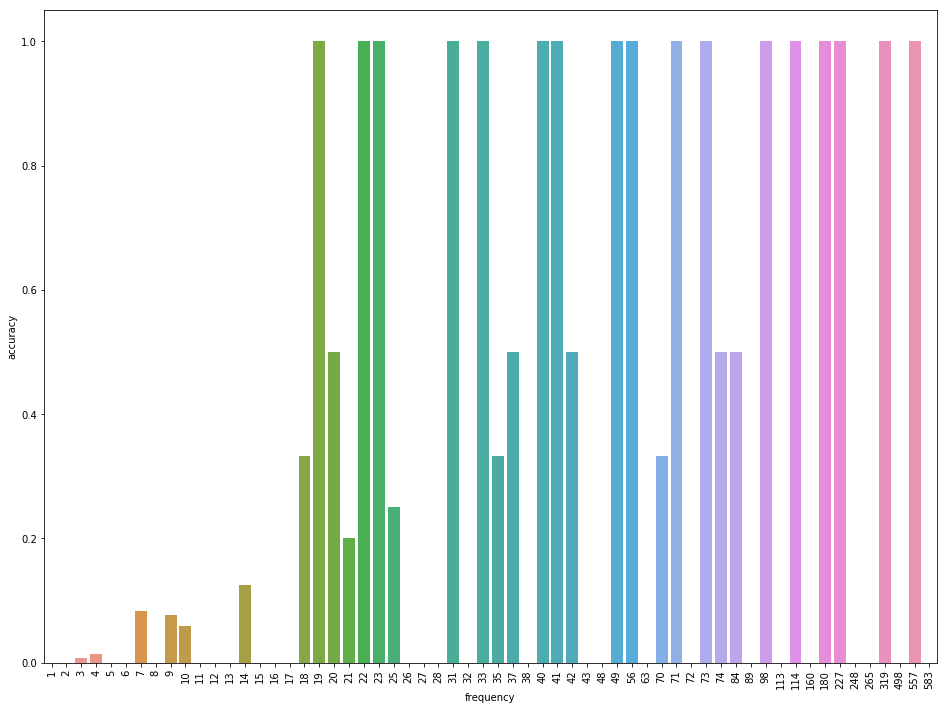

In [132]:
import seaborn as sns
plt.figure(figsize=(16,12))
sns.barplot(x='freq', y=0, data=data)
plt.xticks(rotation=90)
plt.ylabel('accuracy')
plt.xlabel('frequency')
plt.show()
